In [1]:
from tensorflow.keras import layers, models, Model, Input
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from numpy import asarray
from sklearn import model_selection, metrics
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
labels = pd.read_csv('habitat_coding.csv', index_col = 'id')
labels.head(5)
results_folder = "results/below/"

In [2]:
for (columnName, columnData) in labels.iteritems():
    print(labels[columnName].value_counts(normalize=True) * 100)
    print(labels[columnName].value_counts())

1    80.952381
0    19.047619
Name: oxygen_regulation, dtype: float64
1    17
0     4
Name: oxygen_regulation, dtype: int64
2    52.380952
0    28.571429
1    19.047619
Name: radiation_protection, dtype: float64
2    11
0     6
1     4
Name: radiation_protection, dtype: int64
2    80.952381
0    14.285714
1     4.761905
Name: power_generation, dtype: float64
2    17
0     3
1     1
Name: power_generation, dtype: int64
2    71.428571
0    19.047619
1     9.523810
Name: communications_facilities, dtype: float64
2    15
0     4
1     2
Name: communications_facilities, dtype: int64
2    52.380952
1    28.571429
0    19.047619
Name: shape, dtype: float64
2    11
1     6
0     4
Name: shape, dtype: int64
2    57.142857
0    38.095238
1     4.761905
Name: area, dtype: float64
2    12
0     8
1     1
Name: area, dtype: int64
0    66.666667
2    19.047619
1    14.285714
Name: transportation, dtype: float64
0    14
2     4
1     3
Name: transportation, dtype: int64
1    66.666667
0    33.333333


In [3]:
def loadCategorical():
    categorical = pd.read_csv('block_counts_standardized.csv')
    return categorical

In [4]:
categorical = loadCategorical()
categorical.head(5)

,minecraft:crimson_wall_sign,minecraft:slime_block,minecraft:glass,minecraft:red_sand,minecraft:dirt,minecraft:stone,minecraft:water,minecraft:gravel,minecraft:granite,minecraft:lava,...,minecraft:red_sandstone_slab,minecraft:bell,minecraft:yellow_stained_glass,minecraft:small_amethyst_bud,minecraft:medium_amethyst_bud,minecraft:large_amethyst_bud,minecraft:end_crystal,minecraft:jungle_fence,minecraft:brown_bed,minecraft:polished_basalt
0,-0.245967,-0.348352,-0.579534,-0.225605,-1.189214,-0.964071,-0.523749,-0.612106,-0.742615,-0.337418,...,-0.295804,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
1,0.223607,-0.348352,3.386443,-0.900273,1.173070,-0.067146,1.384314,0.836637,0.176084,2.527042,...,-0.295804,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
2,-0.245967,-0.348352,-0.392826,-0.313643,-0.704918,-0.550663,0.520142,-0.261168,-0.702422,-0.337418,...,-0.295804,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
3,-0.245967,1.418849,-0.556195,0.717470,1.065449,1.109615,0.199951,3.410181,3.781978,-0.337418,...,-0.295804,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607
4,-0.245967,-0.348352,-0.652661,-0.043088,-0.279815,0.868461,-0.396361,-0.328656,-0.133977,-0.337418,...,-0.295804,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607,-0.223607


In [5]:
def loadImages():
    train_images_aerial = [None] * len(labels.index)
    train_images_below = [None] * len(labels.index)
    directory = os.path.join(os.getcwd(),'images')
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            extension = filename.find('.')
            prefix = filename[:extension]
            image_num = ""
            for i in prefix: 
                if i.isdigit():
                    image_num += str(i)
            image_num = int(image_num) - 1
            print("Image " + str(image_num) + " has been loaded")
            image = Image.open(f)
            image = image.resize((128,128))
            pic = asarray(image)
            # convert from integers to floats
            pic = pic.astype('float32')
            # normalize to the range 0-1
            pic /= 255.0
            if prefix.__contains__('a'):
                train_images_aerial[image_num] = pic
            else:
                train_images_below[image_num] = pic
    return (train_images_aerial, train_images_below)
        

Image 9 has been loaded
Image 9 has been loaded
Image 10 has been loaded
Image 10 has been loaded
Image 11 has been loaded
Image 11 has been loaded
Image 12 has been loaded
Image 12 has been loaded
Image 13 has been loaded
Image 13 has been loaded
Image 14 has been loaded
Image 14 has been loaded
Image 15 has been loaded
Image 15 has been loaded
Image 16 has been loaded
Image 16 has been loaded
Image 17 has been loaded
Image 17 has been loaded
Image 18 has been loaded
Image 18 has been loaded
Image 0 has been loaded
Image 0 has been loaded
Image 19 has been loaded
Image 19 has been loaded
Image 20 has been loaded
Image 20 has been loaded
Image 1 has been loaded
Image 1 has been loaded
Image 2 has been loaded
Image 2 has been loaded
Image 3 has been loaded
Image 3 has been loaded
Image 4 has been loaded
Image 4 has been loaded
Image 5 has been loaded
Image 5 has been loaded
Image 6 has been loaded
Image 6 has been loaded
Image 7 has been loaded
Image 7 has been loaded
Image 8 has been l

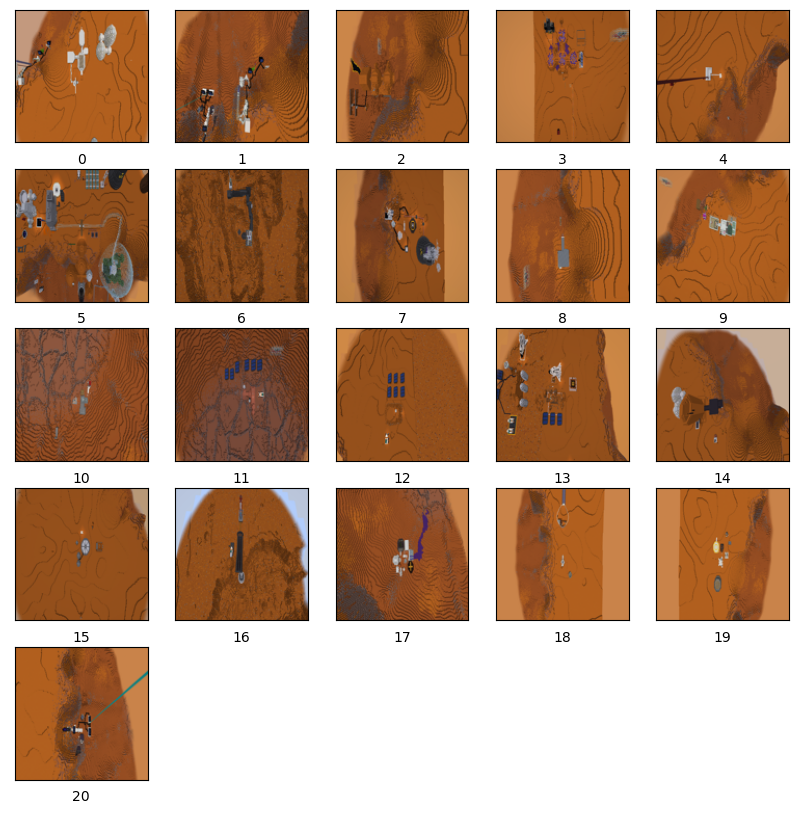

In [6]:
images = loadImages()
plt.figure(figsize=(10,10))
for i in range(len(images[0])):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[0][i])
    plt.xlabel(i)
plt.show()

In [7]:
def createModelImages(num_classes):
    inputA = Input(shape=(128,128,4))
# define our Multi-image CNN network
    x = layers.Conv2D(16, 5, activation='relu')(inputA)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(.8)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(.8)(x)
    x = layers.Dense(16, activation = 'relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_classes, activation = 'softmax')(x)
    x = Model(inputs=inputA, outputs=x)
    x.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return x

In [8]:
def createModelBlockData(num_classes):
    inputB = Input(shape=(551))
    # define MLP network for block data
    x = layers.Dense(500, activation='relu')(inputB)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(250, activation='relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(150, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dense(num_classes, activation = 'softmax')(x)
    x = Model(inputs=inputB, outputs=x)
    x.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return x
    

In [9]:
def combineModels(model_1, model_2, num_classes):
    image_model_merged = layers.Concatenate()([model_1.output, model_2.output])
    output = layers.Dense(128, activation = 'relu')(image_model_merged)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation = 'softmax')(output)
    model = Model(inputs = [(model_1.input,model_2.input)],outputs = output)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [10]:
splits = 5
k_fold = model_selection.StratifiedKFold(n_splits= splits, shuffle = True, random_state = 42)
epochs=1000
results = {
    }  
for (columnName, columnData) in labels.iteritems():
    train_labels = labels[columnName].to_numpy()
    class_labels = np.unique(train_labels)
    num_classes = len(class_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_labels)
    weight_dict = dict(zip(class_labels, class_weights))
    accuracy = []
    precision = []
    recall = []
    f1 = []
    print(columnName)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(images[0], train_labels)):
        print("Split " + str(i+1))
        X_train_aerial = []
        X_train_below = []
        X_train_blocks = []
        y_train = []
        X_test_aerial = []
        X_test_below = []
        X_test_blocks = []
        y_test = []
        for index in train_indices:
            #X_train_aerial.append(images[0][index])
            X_train_below.append(images[1][index])
            #X_train_blocks.append(categorical.iloc[[index]].values.tolist()[0])
            y_train.append(train_labels[index])
        for index in test_indices:
            #X_test_aerial.append(images[0][index])
            X_test_below.append(images[1][index])
            #X_test_blocks.append(categorical.iloc[[index]].values.tolist()[0])
            y_test.append(train_labels[index])
        es = EarlyStopping(monitor='loss', mode='min', patience=3, start_from_epoch = 50,  restore_best_weights=True)
        # models
        #model_aerial = createModelImages(num_classes)
        model_below = createModelImages(num_classes)
        #model_blocks = createModelBlockData(num_classes)
        #image_model = combineModels(model_aerial, model_below, num_classes)
        #combined_model = combineModels(model_below, model_blocks, num_classes)
        #X_train_1 = np.array(X_train_aerial).astype(np.float32)
        X_train_2 = np.array(X_train_below).astype(np.float32)
        #X_train_3 = np.array(X_train_blocks).astype(np.float32)
        history = model_below.fit(
        [X_train_2],
        np.array(y_train),
        class_weight = weight_dict,
        epochs=epochs,
        callbacks=[es]
        )
        #X_test_1 = np.array(X_test_aerial).astype(np.float32)
        X_test_2 = np.array(X_test_below).astype(np.float32)
        #X_test_3 = np.array(X_test_blocks).astype(np.float32)
        predictions = model_below.predict([X_test_2])
        y_pred = []
        for k in range(len(predictions)):
            y_pred.append(np.argmax(predictions[k]))
        #Define scoring metrics
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
        precision.append(metrics.precision_score(y_test, y_pred, average = 'macro'))
        recall.append(metrics.recall_score(y_test, y_pred, average = 'macro'))
        f1.append(metrics.f1_score(y_test, y_pred, average = 'macro')) 
    results[columnName] = {'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'f1_score':f1,
        }

oxygen_regulation
Split 1
Epoch 1/1000


C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


1/1 [==============================] - 1s 1s/step - loss: 1.7704 - accuracy: 0.6875
Epoch 2/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.6182 - accuracy: 0.7500
Epoch 3/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.6645 - accuracy: 0.7500
Epoch 4/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.6710 - accuracy: 0.8750
Epoch 5/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.0864 - accuracy: 0.9375
Epoch 6/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.4428 - accuracy: 0.8125
Epoch 7/1000
1/1 [==============================] - 0s 118ms/step - loss: 1.0680 - accuracy: 0.6875
Epoch 8/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.3376 - accuracy: 0.8750
Epoch 9/1000
1/1 [==============================] - 0s 105ms/step - loss: 0.5255 - accuracy: 0.8750
Epoch 10/1000
1/1 [==============================] - 0s 115ms/step - loss: 0.6897 - accuracy: 0.5625
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.8496 - accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.5178 - accuracy: 0.4118
Epoch 3/1000
1/1 [==============================] - 0s 128ms/step - loss: 1.6055 - accuracy: 0.2353
Epoch 4/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.2204 - accuracy: 0.4118
Epoch 5/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.1309 - accuracy: 0.4706
Epoch 6/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.2481 - accuracy: 0.2941
Epoch 7/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.6449 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.5722 - accuracy: 0.4706
Epoch 9/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.0510 - accuracy: 0.2941
Epoch 10/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.6878 - accuracy: 0.6471
Epoch 11/1000
1

1/1 [==============================] - 0s 122ms/step - loss: 0.6089 - accuracy: 0.7647
Epoch 17/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.3683 - accuracy: 0.7059
Epoch 18/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.7700 - accuracy: 0.5882
Epoch 19/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.4976 - accuracy: 0.7647
Epoch 20/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.3291 - accuracy: 0.7647
Epoch 21/1000
1/1 [==============================] - 0s 136ms/step - loss: 0.4084 - accuracy: 0.7647
Epoch 22/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.2939 - accuracy: 0.7647
Epoch 23/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.2539 - accuracy: 0.8235
Epoch 24/1000
1/1 [==============================] - 0s 157ms/step - loss: 0.3000 - accuracy: 0.8235
Epoch 25/1000
1/1 [==============================] - 0s 158ms/step - loss: 0.1372 - accuracy: 0.9412
Epoc

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.7364 - accuracy: 0.2353
Epoch 2/1000
1/1 [==============================] - 0s 121ms/step - loss: 2.1359 - accuracy: 0.2941
Epoch 3/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.4279 - accuracy: 0.2353
Epoch 4/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.6910 - accuracy: 0.1765
Epoch 5/1000
1/1 [==============================] - 0s 121ms/step - loss: 1.6941 - accuracy: 0.2353
Epoch 6/1000
1/1 [==============================] - 0s 113ms/step - loss: 1.3763 - accuracy: 0.1765
Epoch 7/1000
1/1 [==============================] - 0s 114ms/step - loss: 2.3441 - accuracy: 0.1176
Epoch 8/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.6217 - accuracy: 0.2353
Epoch 9/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.5260 - accuracy: 0.2353
Epoch 10/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.3844 - accuracy: 0.2353
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.2750 - accuracy: 0.7059
Epoch 2/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.2959 - accuracy: 0.7059
Epoch 3/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.5113 - accuracy: 0.7647
Epoch 4/1000
1/1 [==============================] - 0s 120ms/step - loss: 1.8519 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.1871 - accuracy: 0.5882
Epoch 6/1000
1/1 [==============================] - 0s 132ms/step - loss: 0.8527 - accuracy: 0.5294
Epoch 7/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.8212 - accuracy: 0.5294
Epoch 8/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.5588 - accuracy: 0.7647
Epoch 9/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.3685 - accuracy: 0.7647
Epoch 10/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.8182 - accuracy: 0.7059
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


1/1 [==============================] - 1s 1s/step - loss: 1.7558 - accuracy: 0.4375
Epoch 2/1000
1/1 [==============================] - 0s 119ms/step - loss: 2.9246 - accuracy: 0.3125
Epoch 3/1000
1/1 [==============================] - 0s 116ms/step - loss: 1.4966 - accuracy: 0.4375
Epoch 4/1000
1/1 [==============================] - 0s 114ms/step - loss: 2.0768 - accuracy: 0.5000
Epoch 5/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.8052 - accuracy: 0.7500
Epoch 6/1000
1/1 [==============================] - 0s 114ms/step - loss: 1.1470 - accuracy: 0.5625
Epoch 7/1000
1/1 [==============================] - 0s 117ms/step - loss: 2.6257 - accuracy: 0.3750
Epoch 8/1000
1/1 [==============================] - 0s 113ms/step - loss: 1.9309 - accuracy: 0.5000
Epoch 9/1000
1/1 [==============================] - 0s 114ms/step - loss: 1.2046 - accuracy: 0.5625
Epoch 10/1000
1/1 [==============================] - 0s 114ms/step - loss: 1.9877 - accuracy: 0.3750
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.8001 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.9290 - accuracy: 0.2353
Epoch 3/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.8331 - accuracy: 0.2353
Epoch 4/1000
1/1 [==============================] - 0s 115ms/step - loss: 1.7710 - accuracy: 0.4118
Epoch 5/1000
1/1 [==============================] - 0s 126ms/step - loss: 2.1582 - accuracy: 0.3529
Epoch 6/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.3454 - accuracy: 0.4706
Epoch 7/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.1970 - accuracy: 0.5882
Epoch 8/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.1318 - accuracy: 0.5882
Epoch 9/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.9866 - accuracy: 0.5294
Epoch 10/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.1192 - accuracy: 0.4706
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.1672 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 126ms/step - loss: 2.3929 - accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.6214 - accuracy: 0.4118
Epoch 4/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.4526 - accuracy: 0.5882
Epoch 5/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.7779 - accuracy: 0.4706
Epoch 6/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.9226 - accuracy: 0.5294
Epoch 7/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.6908 - accuracy: 0.4118
Epoch 8/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.8954 - accuracy: 0.6471
Epoch 9/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.7308 - accuracy: 0.7059
Epoch 10/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.7430 - accuracy: 0.5294
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.6433 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 134ms/step - loss: 2.8529 - accuracy: 0.1765
Epoch 3/1000
1/1 [==============================] - 0s 132ms/step - loss: 0.9096 - accuracy: 0.4118
Epoch 4/1000
1/1 [==============================] - 0s 136ms/step - loss: 2.3490 - accuracy: 0.5882
Epoch 5/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.2484 - accuracy: 0.4706
Epoch 6/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.1753 - accuracy: 0.5294
Epoch 7/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.1801 - accuracy: 0.5882
Epoch 8/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.7220 - accuracy: 0.4706
Epoch 9/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.9071 - accuracy: 0.4118
Epoch 10/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.1064 - accuracy: 0.5882
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.6663 - accuracy: 0.1765
Epoch 2/1000
1/1 [==============================] - 0s 127ms/step - loss: 2.2787 - accuracy: 0.2941
Epoch 3/1000
1/1 [==============================] - 0s 120ms/step - loss: 2.0642 - accuracy: 0.2353
Epoch 4/1000
1/1 [==============================] - 0s 124ms/step - loss: 2.5150 - accuracy: 0.4118
Epoch 5/1000
1/1 [==============================] - 0s 116ms/step - loss: 1.5137 - accuracy: 0.3529
Epoch 6/1000
1/1 [==============================] - 0s 120ms/step - loss: 2.2740 - accuracy: 0.2941
Epoch 7/1000
1/1 [==============================] - 0s 118ms/step - loss: 1.2499 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 111ms/step - loss: 2.1564 - accuracy: 0.4118
Epoch 9/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.3362 - accuracy: 0.5294
Epoch 10/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.2838 - accuracy: 0.4118
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


1/1 [==============================] - 1s 1s/step - loss: 1.7051 - accuracy: 0.3125
Epoch 2/1000
1/1 [==============================] - 0s 130ms/step - loss: 2.7188 - accuracy: 0.2500
Epoch 3/1000
1/1 [==============================] - 0s 118ms/step - loss: 1.2288 - accuracy: 0.4375
Epoch 4/1000
1/1 [==============================] - 0s 117ms/step - loss: 2.5589 - accuracy: 0.3750
Epoch 5/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.0667 - accuracy: 0.3750
Epoch 6/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.7685 - accuracy: 0.3750
Epoch 7/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.1202 - accuracy: 0.2500
Epoch 8/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.8491 - accuracy: 0.3125
Epoch 9/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.8847 - accuracy: 0.4375
Epoch 10/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.4792 - accuracy: 0.4375
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.3440 - accuracy: 0.0588
Epoch 2/1000
1/1 [==============================] - 0s 121ms/step - loss: 2.9843 - accuracy: 0.1765
Epoch 3/1000
1/1 [==============================] - 0s 125ms/step - loss: 1.6669 - accuracy: 0.2353
Epoch 4/1000
1/1 [==============================] - 0s 119ms/step - loss: 2.9651 - accuracy: 0.1765
Epoch 5/1000
1/1 [==============================] - 0s 112ms/step - loss: 2.6928 - accuracy: 0.1765
Epoch 6/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.1224 - accuracy: 0.3529
Epoch 7/1000
1/1 [==============================] - 0s 118ms/step - loss: 2.5400 - accuracy: 0.4118
Epoch 8/1000
1/1 [==============================] - 0s 115ms/step - loss: 1.4608 - accuracy: 0.2353
Epoch 9/1000
1/1 [==============================] - 0s 120ms/step - loss: 1.3976 - accuracy: 0.4118
Epoch 10/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.9622 - accuracy: 0.2353
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.4089 - accuracy: 0.1176
Epoch 2/1000
1/1 [==============================] - 0s 120ms/step - loss: 1.4011 - accuracy: 0.2353
Epoch 3/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.4380 - accuracy: 0.2353
Epoch 4/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.2547 - accuracy: 0.0588
Epoch 5/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.9927 - accuracy: 0.2353
Epoch 6/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.0211 - accuracy: 0.3529
Epoch 7/1000
1/1 [==============================] - 0s 138ms/step - loss: 0.8117 - accuracy: 0.2941
Epoch 8/1000
1/1 [==============================] - 0s 144ms/step - loss: 0.9648 - accuracy: 0.2353
Epoch 9/1000
1/1 [==============================] - 0s 142ms/step - loss: 0.9027 - accuracy: 0.3529
Epoch 10/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.8418 - accuracy: 0.4118
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.4025 - accuracy: 0.2353
Epoch 2/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.7810 - accuracy: 0.4706
Epoch 3/1000
1/1 [==============================] - 0s 139ms/step - loss: 3.4178 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.3716 - accuracy: 0.2941
Epoch 5/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.5594 - accuracy: 0.2941
Epoch 6/1000
1/1 [==============================] - 0s 138ms/step - loss: 2.6368 - accuracy: 0.2941
Epoch 7/1000
1/1 [==============================] - 0s 137ms/step - loss: 2.7244 - accuracy: 0.0000e+00
Epoch 8/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.3759 - accuracy: 0.6471
Epoch 9/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.3040 - accuracy: 0.4118
Epoch 10/1000
1/1 [==============================] - 0s 138ms/step - loss: 4.5513 - accuracy: 0.5294
Epoch 11/10

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.0710 - accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.9990 - accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 128ms/step - loss: 1.1523 - accuracy: 0.4706
Epoch 4/1000
1/1 [==============================] - 0s 128ms/step - loss: 1.6367 - accuracy: 0.3529
Epoch 5/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.6022 - accuracy: 0.3529
Epoch 6/1000
1/1 [==============================] - 0s 129ms/step - loss: 0.9398 - accuracy: 0.7059
Epoch 7/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.9257 - accuracy: 0.7059
Epoch 8/1000
1/1 [==============================] - 0s 129ms/step - loss: 0.9846 - accuracy: 0.4706
Epoch 9/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.9182 - accuracy: 0.4118
Epoch 10/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.3080 - accuracy: 0.4706
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


1/1 [==============================] - 1s 992ms/step - loss: 1.5551 - accuracy: 0.3125
Epoch 2/1000
1/1 [==============================] - 0s 120ms/step - loss: 1.6438 - accuracy: 0.6250
Epoch 3/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.8797 - accuracy: 0.4375
Epoch 4/1000
1/1 [==============================] - 0s 116ms/step - loss: 1.0565 - accuracy: 0.3125
Epoch 5/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.6128 - accuracy: 0.1250
Epoch 6/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.0511 - accuracy: 0.2500
Epoch 7/1000
1/1 [==============================] - 0s 112ms/step - loss: 1.3874 - accuracy: 0.5625
Epoch 8/1000
1/1 [==============================] - 0s 114ms/step - loss: 0.6670 - accuracy: 0.6875
Epoch 9/1000
1/1 [==============================] - 0s 117ms/step - loss: 0.7563 - accuracy: 0.4375
Epoch 10/1000
1/1 [==============================] - 0s 113ms/step - loss: 0.9550 - accuracy: 0.3125
Epoch 11/100

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.9113 - accuracy: 0.4118
Epoch 2/1000
1/1 [==============================] - 0s 127ms/step - loss: 3.0341 - accuracy: 0.4706
Epoch 3/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.1956 - accuracy: 0.2941
Epoch 4/1000
1/1 [==============================] - 0s 121ms/step - loss: 1.4962 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 115ms/step - loss: 1.8835 - accuracy: 0.4118
Epoch 6/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.4127 - accuracy: 0.6471
Epoch 7/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.7479 - accuracy: 0.4118
Epoch 8/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.6591 - accuracy: 0.5294
Epoch 9/1000
1/1 [==============================] - 0s 112ms/step - loss: 0.9205 - accuracy: 0.5882
Epoch 10/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.2909 - accuracy: 0.5882
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 3.7074 - accuracy: 0.5294
Epoch 2/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.9111 - accuracy: 0.7647
Epoch 3/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.7067 - accuracy: 0.4118
Epoch 4/1000
1/1 [==============================] - 0s 122ms/step - loss: 2.9617 - accuracy: 0.4118
Epoch 5/1000
1/1 [==============================] - 0s 119ms/step - loss: 0.9850 - accuracy: 0.4118
Epoch 6/1000
1/1 [==============================] - 0s 121ms/step - loss: 1.5976 - accuracy: 0.1765
Epoch 7/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.8858 - accuracy: 0.5882
Epoch 8/1000
1/1 [==============================] - 0s 121ms/step - loss: 0.8531 - accuracy: 0.5882
Epoch 9/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.2404 - accuracy: 0.8824
Epoch 10/1000
1/1 [==============================] - 0s 118ms/step - loss: 1.1569 - accuracy: 0.7059
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.4261 - accuracy: 0.5294
Epoch 2/1000
1/1 [==============================] - 0s 128ms/step - loss: 4.0287 - accuracy: 0.5294
Epoch 3/1000
1/1 [==============================] - 0s 109ms/step - loss: 1.1051 - accuracy: 0.5882
Epoch 4/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.1913 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.8954 - accuracy: 0.4706
Epoch 6/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.7640 - accuracy: 0.5294
Epoch 7/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.1974 - accuracy: 0.7059
Epoch 8/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.9219 - accuracy: 0.6471
Epoch 9/1000
1/1 [==============================] - 0s 128ms/step - loss: 1.2092 - accuracy: 0.5882
Epoch 10/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.0691 - accuracy: 0.7059
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.9247 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.5996 - accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 126ms/step - loss: 2.0388 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.7448 - accuracy: 0.3529
Epoch 5/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.8595 - accuracy: 0.5294
Epoch 6/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.6816 - accuracy: 0.4118
Epoch 7/1000
1/1 [==============================] - 0s 125ms/step - loss: 1.3269 - accuracy: 0.5882
Epoch 8/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.4206 - accuracy: 0.8235
Epoch 9/1000
1/1 [==============================] - 0s 122ms/step - loss: 0.6656 - accuracy: 0.6471
Epoch 10/1000
1/1 [==============================] - 0s 122ms/step - loss: 0.8220 - accuracy: 0.6471
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 2.0604 - accuracy: 0.3750
Epoch 2/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.5762 - accuracy: 0.4375
Epoch 3/1000
1/1 [==============================] - 0s 142ms/step - loss: 0.9114 - accuracy: 0.6250
Epoch 4/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.4014 - accuracy: 0.4375
Epoch 5/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.2316 - accuracy: 0.5625
Epoch 6/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.2254 - accuracy: 0.6250
Epoch 7/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.2010 - accuracy: 0.5000
Epoch 8/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.7379 - accuracy: 0.7500
Epoch 9/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.0617 - accuracy: 0.5625
Epoch 10/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.0025 - accuracy: 0.5000
Ep

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.3855 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.8381 - accuracy: 0.2941
Epoch 3/1000
1/1 [==============================] - 0s 135ms/step - loss: 2.1963 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.3598 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.1477 - accuracy: 0.5882
Epoch 6/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4958 - accuracy: 0.2941
Epoch 7/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.2605 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.0085 - accuracy: 0.5294
Epoch 9/1000
1/1 [==============================] - 0s 135ms/step - loss: 0.9912 - accuracy: 0.6471
Epoch 10/1000
1/1 [==============================] - 0s 137ms/step - loss: 0.6782 - accuracy: 0.5882
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 3.7163 - accuracy: 0.4706
Epoch 2/1000
1/1 [==============================] - 0s 130ms/step - loss: 2.5583 - accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.7579 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 130ms/step - loss: 2.1315 - accuracy: 0.5294
Epoch 5/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.9628 - accuracy: 0.3529
Epoch 6/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.1125 - accuracy: 0.6471
Epoch 7/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.5165 - accuracy: 0.7647
Epoch 8/1000
1/1 [==============================] - 0s 126ms/step - loss: 2.0081 - accuracy: 0.4706
Epoch 9/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.8797 - accuracy: 0.5882
Epoch 10/1000
1/1 [==============================] - 0s 129ms/step - loss: 0.9918 - accuracy: 0.5882
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 3.5642 - accuracy: 0.1176
Epoch 2/1000
1/1 [==============================] - 0s 129ms/step - loss: 2.5332 - accuracy: 0.1765
Epoch 3/1000
1/1 [==============================] - 0s 123ms/step - loss: 2.2969 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.8203 - accuracy: 0.2941
Epoch 5/1000
1/1 [==============================] - 0s 121ms/step - loss: 1.6473 - accuracy: 0.4706
Epoch 6/1000
1/1 [==============================] - 0s 120ms/step - loss: 1.3660 - accuracy: 0.3529
Epoch 7/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.9273 - accuracy: 0.2353
Epoch 8/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.6248 - accuracy: 0.4118
Epoch 9/1000
1/1 [==============================] - 0s 125ms/step - loss: 1.1813 - accuracy: 0.5294
Epoch 10/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.0230 - accuracy: 0.4118
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.2526 - accuracy: 0.4706
Epoch 2/1000
1/1 [==============================] - 0s 132ms/step - loss: 2.0551 - accuracy: 0.4118
Epoch 3/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.3539 - accuracy: 0.5294
Epoch 4/1000
1/1 [==============================] - 0s 134ms/step - loss: 2.5931 - accuracy: 0.3529
Epoch 5/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.5084 - accuracy: 0.5294
Epoch 6/1000
1/1 [==============================] - 0s 159ms/step - loss: 1.1226 - accuracy: 0.5882
Epoch 7/1000
1/1 [==============================] - 0s 146ms/step - loss: 0.9114 - accuracy: 0.6471
Epoch 8/1000
1/1 [==============================] - 0s 135ms/step - loss: 0.8423 - accuracy: 0.4706
Epoch 9/1000
1/1 [==============================] - 0s 157ms/step - loss: 0.9783 - accuracy: 0.4706
Epoch 10/1000
1/1 [==============================] - 0s 162ms/step - loss: 0.7283 - accuracy: 0.7059
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


1/1 [==============================] - 1s 1s/step - loss: 1.5881 - accuracy: 0.4375
Epoch 2/1000
1/1 [==============================] - 0s 137ms/step - loss: 0.7638 - accuracy: 0.5000
Epoch 3/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.5986 - accuracy: 0.5625
Epoch 4/1000
1/1 [==============================] - 0s 143ms/step - loss: 0.5343 - accuracy: 0.5625
Epoch 5/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.1630 - accuracy: 0.3750
Epoch 6/1000
1/1 [==============================] - 0s 142ms/step - loss: 0.9308 - accuracy: 0.5000
Epoch 7/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.7405 - accuracy: 0.6250
Epoch 8/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.3385 - accuracy: 0.3125
Epoch 9/1000
1/1 [==============================] - 0s 149ms/step - loss: 0.8337 - accuracy: 0.4375
Epoch 10/1000
1/1 [==============================] - 0s 175ms/step - loss: 0.7785 - accuracy: 0.3750
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 2s 2s/step - loss: 2.0070 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.7547 - accuracy: 0.4118
Epoch 3/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.1853 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 171ms/step - loss: 1.4184 - accuracy: 0.2941
Epoch 5/1000
1/1 [==============================] - 0s 163ms/step - loss: 1.9042 - accuracy: 0.2941
Epoch 6/1000
1/1 [==============================] - 0s 168ms/step - loss: 0.9925 - accuracy: 0.3529
Epoch 7/1000
1/1 [==============================] - 0s 146ms/step - loss: 1.4630 - accuracy: 0.2941
Epoch 8/1000
1/1 [==============================] - 0s 138ms/step - loss: 0.8546 - accuracy: 0.5294
Epoch 9/1000
1/1 [==============================] - 0s 165ms/step - loss: 0.7002 - accuracy: 0.5882
Epoch 10/1000
1/1 [==============================] - 0s 169ms/step - loss: 1.3239 - accuracy: 0.3529
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 3.9146 - accuracy: 0.2353
Epoch 2/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.7728 - accuracy: 0.5882
Epoch 3/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.7207 - accuracy: 0.5882
Epoch 4/1000
1/1 [==============================] - 0s 159ms/step - loss: 1.8147 - accuracy: 0.5294
Epoch 5/1000
1/1 [==============================] - 0s 166ms/step - loss: 1.6026 - accuracy: 0.5882
Epoch 6/1000
1/1 [==============================] - 0s 150ms/step - loss: 1.4501 - accuracy: 0.7059
Epoch 7/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.1073 - accuracy: 0.7059
Epoch 8/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.6727 - accuracy: 0.6471
Epoch 9/1000
1/1 [==============================] - 0s 144ms/step - loss: 0.7039 - accuracy: 0.6471
Epoch 10/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.7742 - accuracy: 0.7059
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.4997 - accuracy: 0.4118
Epoch 2/1000
1/1 [==============================] - 0s 143ms/step - loss: 2.1244 - accuracy: 0.2353
Epoch 3/1000
1/1 [==============================] - 0s 147ms/step - loss: 1.1086 - accuracy: 0.5294
Epoch 4/1000
1/1 [==============================] - 0s 160ms/step - loss: 2.0567 - accuracy: 0.1765
Epoch 5/1000
1/1 [==============================] - 0s 146ms/step - loss: 1.3599 - accuracy: 0.5294
Epoch 6/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.7330 - accuracy: 0.5294
Epoch 7/1000
1/1 [==============================] - 0s 156ms/step - loss: 1.1872 - accuracy: 0.4118
Epoch 8/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.5777 - accuracy: 0.5294
Epoch 9/1000
1/1 [==============================] - 0s 149ms/step - loss: 0.6648 - accuracy: 0.8235
Epoch 10/1000
1/1 [==============================] - 0s 156ms/step - loss: 1.3336 - accuracy: 0.5294
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.5069 - accuracy: 0.4118
Epoch 2/1000
1/1 [==============================] - 0s 158ms/step - loss: 1.9850 - accuracy: 0.2941
Epoch 3/1000
1/1 [==============================] - 0s 166ms/step - loss: 1.3631 - accuracy: 0.2941
Epoch 4/1000
1/1 [==============================] - 0s 157ms/step - loss: 1.6214 - accuracy: 0.2941
Epoch 5/1000
1/1 [==============================] - 0s 156ms/step - loss: 1.1380 - accuracy: 0.5294
Epoch 6/1000
1/1 [==============================] - 0s 182ms/step - loss: 1.3347 - accuracy: 0.3529
Epoch 7/1000
1/1 [==============================] - 0s 176ms/step - loss: 1.6624 - accuracy: 0.2941
Epoch 8/1000
1/1 [==============================] - 0s 184ms/step - loss: 0.9068 - accuracy: 0.4706
Epoch 9/1000
1/1 [==============================] - 0s 153ms/step - loss: 0.8644 - accuracy: 0.4706
Epoch 10/1000
1/1 [==============================] - 0s 170ms/step - loss: 0.8958 - accuracy: 0.5294
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


1/1 [==============================] - 1s 1s/step - loss: 1.9695 - accuracy: 0.5000
Epoch 2/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.0775 - accuracy: 0.6250
Epoch 3/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.2176 - accuracy: 0.5000
Epoch 4/1000
1/1 [==============================] - 0s 143ms/step - loss: 0.8269 - accuracy: 0.6250
Epoch 5/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.3406 - accuracy: 0.3750
Epoch 6/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.7021 - accuracy: 0.7500
Epoch 7/1000
1/1 [==============================] - 0s 138ms/step - loss: 0.9163 - accuracy: 0.8750
Epoch 8/1000
1/1 [==============================] - 0s 144ms/step - loss: 0.9082 - accuracy: 0.6250
Epoch 9/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.1583 - accuracy: 0.6250
Epoch 10/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.1196 - accuracy: 0.7500
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.2569 - accuracy: 0.4706
Epoch 2/1000
1/1 [==============================] - 0s 127ms/step - loss: 3.3075 - accuracy: 0.5294
Epoch 3/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.7648 - accuracy: 0.5294
Epoch 4/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.9357 - accuracy: 0.8235
Epoch 5/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.9418 - accuracy: 0.7059
Epoch 6/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.9268 - accuracy: 0.6471
Epoch 7/1000
1/1 [==============================] - 0s 127ms/step - loss: 2.0555 - accuracy: 0.5294
Epoch 8/1000
1/1 [==============================] - 0s 127ms/step - loss: 2.3080 - accuracy: 0.5882
Epoch 9/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.7072 - accuracy: 0.8235
Epoch 10/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.1774 - accuracy: 0.6471
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.2794 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 129ms/step - loss: 2.3247 - accuracy: 0.1765
Epoch 3/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.7896 - accuracy: 0.1765
Epoch 4/1000
1/1 [==============================] - 0s 126ms/step - loss: 2.4786 - accuracy: 0.2353
Epoch 5/1000
1/1 [==============================] - 0s 126ms/step - loss: 2.6545 - accuracy: 0.1176
Epoch 6/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.3536 - accuracy: 0.3529
Epoch 7/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.2764 - accuracy: 0.2941
Epoch 8/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.2142 - accuracy: 0.3529
Epoch 9/1000
1/1 [==============================] - 0s 122ms/step - loss: 0.9662 - accuracy: 0.2941
Epoch 10/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.3940 - accuracy: 0.1765
Epoch 11/1000
1

1/1 [==============================] - 0s 151ms/step - loss: 1.6619 - accuracy: 0.3529
Epoch 23/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.2593 - accuracy: 0.4118
Epoch 24/1000
1/1 [==============================] - 0s 145ms/step - loss: 1.0941 - accuracy: 0.5882
Epoch 25/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.0489 - accuracy: 0.5294
Epoch 26/1000
1/1 [==============================] - 0s 145ms/step - loss: 1.1364 - accuracy: 0.5294
Epoch 27/1000
1/1 [==============================] - 0s 144ms/step - loss: 0.8417 - accuracy: 0.5294
Epoch 28/1000
1/1 [==============================] - 0s 146ms/step - loss: 0.7157 - accuracy: 0.7059
Epoch 29/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.8642 - accuracy: 0.4118
Epoch 30/1000
1/1 [==============================] - 0s 147ms/step - loss: 0.8847 - accuracy: 0.5882
Epoch 31/1000
1/1 [==============================] - 0s 143ms/step - loss: 0.3596 - accuracy: 0.8235
Epoc

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.6824 - accuracy: 0.5294
Epoch 2/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.7121 - accuracy: 0.4118
Epoch 3/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.9539 - accuracy: 0.2941
Epoch 4/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.6166 - accuracy: 0.3529
Epoch 5/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.9432 - accuracy: 0.3529
Epoch 6/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.1952 - accuracy: 0.4118
Epoch 7/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.1347 - accuracy: 0.5882
Epoch 8/1000
1/1 [==============================] - 0s 132ms/step - loss: 0.8737 - accuracy: 0.5882
Epoch 9/1000
1/1 [==============================] - 0s 133ms/step - loss: 0.9186 - accuracy: 0.4118
Epoch 10/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.4919 - accuracy: 0.8235
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.9644 - accuracy: 0.6250
Epoch 2/1000
1/1 [==============================] - 0s 127ms/step - loss: 0.9179 - accuracy: 0.6875
Epoch 3/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.6364 - accuracy: 0.8125
Epoch 4/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.9319 - accuracy: 0.6875
Epoch 5/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.0353 - accuracy: 0.7500
Epoch 6/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.5645 - accuracy: 0.6875
Epoch 7/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.7882 - accuracy: 0.6250
Epoch 8/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.7918 - accuracy: 0.8750
Epoch 9/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.2263 - accuracy: 0.7500
Epoch 10/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.1510 - accuracy: 0.7500
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 0.9509 - accuracy: 0.4118
Epoch 2/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.2419 - accuracy: 0.5294
Epoch 3/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.8520 - accuracy: 0.5882
Epoch 4/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.5228 - accuracy: 0.3529
Epoch 5/1000
1/1 [==============================] - 0s 124ms/step - loss: 0.6901 - accuracy: 0.6471
Epoch 6/1000
1/1 [==============================] - 0s 127ms/step - loss: 0.8834 - accuracy: 0.5882
Epoch 7/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.8947 - accuracy: 0.5294
Epoch 8/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.5508 - accuracy: 0.8235
Epoch 9/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.3834 - accuracy: 0.7059
Epoch 10/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.7413 - accuracy: 0.6471
Epoch 11/1000
1

1/1 [==============================] - 0s 135ms/step - loss: 0.3718 - accuracy: 0.8235
Epoch 28/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.1621 - accuracy: 0.9412
Epoch 29/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.1935 - accuracy: 0.8824
Epoch 30/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.1011 - accuracy: 1.0000
Epoch 31/1000
1/1 [==============================] - 0s 132ms/step - loss: 0.0567 - accuracy: 1.0000
Epoch 32/1000
1/1 [==============================] - 0s 139ms/step - loss: 0.1950 - accuracy: 0.9412
Epoch 33/1000
1/1 [==============================] - 0s 132ms/step - loss: 0.0943 - accuracy: 1.0000
Epoch 34/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.1065 - accuracy: 1.0000
Epoch 35/1000
1/1 [==============================] - 0s 133ms/step - loss: 0.1153 - accuracy: 1.0000
Epoch 36/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.1271 - accuracy: 1.0000
Epoc

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.5733 - accuracy: 0.7647
Epoch 2/1000
1/1 [==============================] - 0s 122ms/step - loss: 0.7104 - accuracy: 0.7059
Epoch 3/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.9100 - accuracy: 0.6471
Epoch 4/1000
1/1 [==============================] - 0s 130ms/step - loss: 0.7592 - accuracy: 0.7647
Epoch 5/1000
1/1 [==============================] - 0s 122ms/step - loss: 0.4515 - accuracy: 0.8824
Epoch 6/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.6021 - accuracy: 0.7647
Epoch 7/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.3457 - accuracy: 0.7059
Epoch 8/1000
1/1 [==============================] - 0s 132ms/step - loss: 0.6750 - accuracy: 0.7647
Epoch 9/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.0262 - accuracy: 0.7059
Epoch 10/1000
1/1 [==============================] - 0s 123ms/step - loss: 0.4770 - accuracy: 0.8235
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.2104 - accuracy: 0.5294
Epoch 2/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.4436 - accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.1317 - accuracy: 0.6471
Epoch 4/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.1833 - accuracy: 0.6471
Epoch 5/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.8007 - accuracy: 0.8235
Epoch 6/1000
1/1 [==============================] - 0s 140ms/step - loss: 0.3912 - accuracy: 0.7647
Epoch 7/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.0851 - accuracy: 0.7059
Epoch 8/1000
1/1 [==============================] - 0s 136ms/step - loss: 0.7604 - accuracy: 0.7059
Epoch 9/1000
1/1 [==============================] - 0s 135ms/step - loss: 0.8689 - accuracy: 0.6471
Epoch 10/1000
1/1 [==============================] - 0s 139ms/step - loss: 0.2983 - accuracy: 0.8235
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.2909 - accuracy: 0.2500
Epoch 2/1000
1/1 [==============================] - 0s 131ms/step - loss: 3.9270 - accuracy: 0.2500
Epoch 3/1000
1/1 [==============================] - 0s 140ms/step - loss: 2.1446 - accuracy: 0.2500
Epoch 4/1000
1/1 [==============================] - 0s 164ms/step - loss: 2.9400 - accuracy: 0.3750
Epoch 5/1000
1/1 [==============================] - 0s 169ms/step - loss: 2.2178 - accuracy: 0.5000
Epoch 6/1000
1/1 [==============================] - 0s 167ms/step - loss: 3.0417 - accuracy: 0.3125
Epoch 7/1000
1/1 [==============================] - 0s 164ms/step - loss: 2.1888 - accuracy: 0.3750
Epoch 8/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.8255 - accuracy: 0.3750
Epoch 9/1000
1/1 [==============================] - 0s 120ms/step - loss: 2.1120 - accuracy: 0.4375
Epoch 10/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.3788 - accuracy: 0.4375
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.2109 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 165ms/step - loss: 1.7439 - accuracy: 0.5294
Epoch 3/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.7420 - accuracy: 0.5882
Epoch 4/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.4924 - accuracy: 0.4118
Epoch 5/1000
1/1 [==============================] - 0s 161ms/step - loss: 1.1507 - accuracy: 0.6471
Epoch 6/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.1844 - accuracy: 0.4706
Epoch 7/1000
1/1 [==============================] - 0s 149ms/step - loss: 1.1952 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 181ms/step - loss: 1.2452 - accuracy: 0.4118
Epoch 9/1000
1/1 [==============================] - 0s 149ms/step - loss: 1.1057 - accuracy: 0.4118
Epoch 10/1000
1/1 [==============================] - 0s 138ms/step - loss: 0.8734 - accuracy: 0.5882
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.1449 - accuracy: 0.2353
Epoch 2/1000
1/1 [==============================] - 0s 157ms/step - loss: 1.8846 - accuracy: 0.2941
Epoch 3/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.5839 - accuracy: 0.4706
Epoch 4/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.1693 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 148ms/step - loss: 1.2536 - accuracy: 0.6471
Epoch 6/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.1675 - accuracy: 0.5294
Epoch 7/1000
1/1 [==============================] - 0s 143ms/step - loss: 0.9143 - accuracy: 0.6471
Epoch 8/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.1166 - accuracy: 0.4706
Epoch 9/1000
1/1 [==============================] - 0s 161ms/step - loss: 1.1480 - accuracy: 0.6471
Epoch 10/1000
1/1 [==============================] - 0s 178ms/step - loss: 1.5654 - accuracy: 0.3529
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.1639 - accuracy: 0.5294
Epoch 2/1000
1/1 [==============================] - 0s 130ms/step - loss: 2.0160 - accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.6249 - accuracy: 0.5294
Epoch 4/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.5615 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.9578 - accuracy: 0.4706
Epoch 6/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.1910 - accuracy: 0.4706
Epoch 7/1000
1/1 [==============================] - 0s 126ms/step - loss: 1.3462 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 129ms/step - loss: 0.8999 - accuracy: 0.5294
Epoch 9/1000
1/1 [==============================] - 0s 127ms/step - loss: 0.9147 - accuracy: 0.5882
Epoch 10/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.8164 - accuracy: 0.7059
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 3.7321 - accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 156ms/step - loss: 2.2350 - accuracy: 0.4706
Epoch 3/1000
1/1 [==============================] - 0s 172ms/step - loss: 1.9975 - accuracy: 0.4118
Epoch 4/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.9103 - accuracy: 0.4118
Epoch 5/1000
1/1 [==============================] - 0s 127ms/step - loss: 2.8024 - accuracy: 0.2941
Epoch 6/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4283 - accuracy: 0.5882
Epoch 7/1000
1/1 [==============================] - 0s 170ms/step - loss: 1.8653 - accuracy: 0.4118
Epoch 8/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.4405 - accuracy: 0.5882
Epoch 9/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.1222 - accuracy: 0.5882
Epoch 10/1000
1/1 [==============================] - 0s 167ms/step - loss: 1.3333 - accuracy: 0.4706
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


1/1 [==============================] - 1s 1s/step - loss: 1.4639 - accuracy: 0.1875
Epoch 2/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.5191 - accuracy: 0.3125
Epoch 3/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.2430 - accuracy: 0.4375
Epoch 4/1000
1/1 [==============================] - 0s 126ms/step - loss: 0.8970 - accuracy: 0.6250
Epoch 5/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.3914 - accuracy: 0.5000
Epoch 6/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.3849 - accuracy: 0.8125
Epoch 7/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.0646 - accuracy: 0.5625
Epoch 8/1000
1/1 [==============================] - 0s 118ms/step - loss: 0.7159 - accuracy: 0.5625
Epoch 9/1000
1/1 [==============================] - 0s 120ms/step - loss: 0.6906 - accuracy: 0.6875
Epoch 10/1000
1/1 [==============================] - 0s 116ms/step - loss: 0.3359 - accuracy: 0.8125
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 1.7299 - accuracy: 0.4706
Epoch 2/1000
1/1 [==============================] - 0s 136ms/step - loss: 2.4754 - accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.5932 - accuracy: 0.6471
Epoch 4/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.2498 - accuracy: 0.6471
Epoch 5/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.6188 - accuracy: 0.5882
Epoch 6/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.3282 - accuracy: 0.5882
Epoch 7/1000
1/1 [==============================] - 0s 145ms/step - loss: 1.7900 - accuracy: 0.5294
Epoch 8/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.3612 - accuracy: 0.5882
Epoch 9/1000
1/1 [==============================] - 0s 134ms/step - loss: 2.2852 - accuracy: 0.7059
Epoch 10/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.7322 - accuracy: 0.5294
Ep

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.6256 - accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 135ms/step - loss: 2.3483 - accuracy: 0.1176
Epoch 3/1000
1/1 [==============================] - 0s 140ms/step - loss: 3.0680 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 172ms/step - loss: 1.0968 - accuracy: 0.4118
Epoch 5/1000
1/1 [==============================] - 0s 155ms/step - loss: 1.2427 - accuracy: 0.2941
Epoch 6/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.1044 - accuracy: 0.4706
Epoch 7/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.1425 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 174ms/step - loss: 2.8308 - accuracy: 0.1765
Epoch 9/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.1318 - accuracy: 0.4706
Epoch 10/1000
1/1 [==============================] - 0s 158ms/step - loss: 0.8674 - accuracy: 0.3529
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.9189 - accuracy: 0.2941
Epoch 2/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.3202 - accuracy: 0.2353
Epoch 3/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.4100 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.1613 - accuracy: 0.2941
Epoch 5/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.3160 - accuracy: 0.3529
Epoch 6/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.3333 - accuracy: 0.2941
Epoch 7/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.9956 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.1653 - accuracy: 0.2353
Epoch 9/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.0683 - accuracy: 0.3529
Epoch 10/1000
1/1 [==============================] - 0s 133ms/step - loss: 0.8464 - accuracy: 0.3529
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 2.2391 - accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.4524 - accuracy: 0.4706
Epoch 3/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.8781 - accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.2022 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.8133 - accuracy: 0.5294
Epoch 6/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.3492 - accuracy: 0.4118
Epoch 7/1000
1/1 [==============================] - 0s 128ms/step - loss: 0.6691 - accuracy: 0.5882
Epoch 8/1000
1/1 [==============================] - 0s 128ms/step - loss: 1.1800 - accuracy: 0.5294
Epoch 9/1000
1/1 [==============================] - 0s 145ms/step - loss: 1.0985 - accuracy: 0.4118
Epoch 10/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.1341 - accuracy: 0.5294
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.7798 - accuracy: 0.4375
Epoch 2/1000
1/1 [==============================] - 0s 139ms/step - loss: 0.9853 - accuracy: 0.4375
Epoch 3/1000
1/1 [==============================] - 0s 159ms/step - loss: 1.4323 - accuracy: 0.5000
Epoch 4/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.6915 - accuracy: 0.3750
Epoch 5/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.2872 - accuracy: 0.6250
Epoch 6/1000
1/1 [==============================] - 0s 161ms/step - loss: 0.5169 - accuracy: 0.8125
Epoch 7/1000
1/1 [==============================] - 0s 154ms/step - loss: 1.4441 - accuracy: 0.2500
Epoch 8/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.3752 - accuracy: 0.8125
Epoch 9/1000
1/1 [==============================] - 0s 161ms/step - loss: 0.4621 - accuracy: 0.8125
Epoch 10/1000
1/1 [==============================] - 0s 138ms/step - loss: 0.2593 - accuracy: 0.8125
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.0648 - accuracy: 0.5882
Epoch 2/1000
1/1 [==============================] - 0s 161ms/step - loss: 1.5476 - accuracy: 0.4118
Epoch 3/1000
1/1 [==============================] - 0s 174ms/step - loss: 0.5294 - accuracy: 0.8824
Epoch 4/1000
1/1 [==============================] - 0s 179ms/step - loss: 1.2027 - accuracy: 0.4706
Epoch 5/1000
1/1 [==============================] - 0s 152ms/step - loss: 1.6203 - accuracy: 0.5294
Epoch 6/1000
1/1 [==============================] - 0s 136ms/step - loss: 0.8677 - accuracy: 0.7059
Epoch 7/1000
1/1 [==============================] - 0s 140ms/step - loss: 0.5717 - accuracy: 0.8235
Epoch 8/1000
1/1 [==============================] - 0s 137ms/step - loss: 0.5029 - accuracy: 0.7059
Epoch 9/1000
1/1 [==============================] - 0s 166ms/step - loss: 0.7191 - accuracy: 0.7647
Epoch 10/1000
1/1 [==============================] - 0s 173ms/step - loss: 0.9752 - accuracy: 0.7647
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.6361 - accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.8405 - accuracy: 0.2941
Epoch 3/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.0544 - accuracy: 0.5294
Epoch 4/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.7514 - accuracy: 0.5882
Epoch 5/1000
1/1 [==============================] - 0s 139ms/step - loss: 0.9046 - accuracy: 0.5882
Epoch 6/1000
1/1 [==============================] - 0s 136ms/step - loss: 0.8414 - accuracy: 0.5882
Epoch 7/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.1883 - accuracy: 0.4706
Epoch 8/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.0612 - accuracy: 0.5882
Epoch 9/1000
1/1 [==============================] - 0s 136ms/step - loss: 0.5605 - accuracy: 0.8235
Epoch 10/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.3274 - accuracy: 0.8824
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.9037 - accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 131ms/step - loss: 0.7594 - accuracy: 0.7059
Epoch 3/1000
1/1 [==============================] - 0s 135ms/step - loss: 0.7410 - accuracy: 0.6471
Epoch 4/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.2467 - accuracy: 0.6471
Epoch 5/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.9798 - accuracy: 0.5882
Epoch 6/1000
1/1 [==============================] - 0s 135ms/step - loss: 0.8369 - accuracy: 0.7647
Epoch 7/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.9880 - accuracy: 0.6471
Epoch 8/1000
1/1 [==============================] - 0s 138ms/step - loss: 0.3579 - accuracy: 0.8235
Epoch 9/1000
1/1 [==============================] - 0s 134ms/step - loss: 0.3117 - accuracy: 0.7647
Epoch 10/1000
1/1 [==============================] - 0s 133ms/step - loss: 0.7642 - accuracy: 0.7059
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 1s 1s/step - loss: 1.0078 - accuracy: 0.5294
Epoch 2/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.7352 - accuracy: 0.4118
Epoch 3/1000
1/1 [==============================] - 0s 135ms/step - loss: 0.8534 - accuracy: 0.5882
Epoch 4/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.2150 - accuracy: 0.6471
Epoch 5/1000
1/1 [==============================] - 0s 136ms/step - loss: 0.6914 - accuracy: 0.7059
Epoch 6/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.1605 - accuracy: 0.7059
Epoch 7/1000
1/1 [==============================] - 0s 142ms/step - loss: 0.4688 - accuracy: 0.8824
Epoch 8/1000
1/1 [==============================] - 0s 139ms/step - loss: 0.1221 - accuracy: 0.9412
Epoch 9/1000
1/1 [==============================] - 0s 141ms/step - loss: 0.2793 - accuracy: 0.8824
Epoch 10/1000
1/1 [==============================] - 0s 138ms/step - loss: 0.1039 - accuracy: 1.0000
Epoch 11/1000
1

C:\Users\humdi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
#Plot Seaborn plots to visualize results
x_label = 'Feature'
df_accuracy = pd.DataFrame(columns = [x_label, 'Accuracy'])
df_precision = pd.DataFrame(columns = [x_label, 'Precision'])
df_recall = pd.DataFrame(columns = [x_label, 'Recall'])
df_f1 = pd.DataFrame(columns = [x_label, 'F1 Score'])
for key in results:
    for metric in results[key]:
        for k in range(splits):
            if metric == 'accuracy':
                df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]}, 
                ignore_index = True)
            elif metric == 'precision':
                df_precision = df_precision.append({x_label : key, 'Precision': results[key][metric][k]}, 
                ignore_index = True)
            elif metric == 'recall':
                df_recall = df_recall.append({x_label : key, 'Recall': results[key][metric][k]}, 
                ignore_index = True)
            else:
                df_f1 = df_f1.append({x_label : key, 'F1 Score': results[key][metric][k]}, 
                ignore_index = True)
        msg = "%s: %f (%f)" % (key+" "+metric, np.mean(results[key][metric]), np.std(results[key][metric]))
        print(msg)
df_accuracy.to_csv(results_folder+"accuracy.csv", index = False)
df_precision.to_csv(results_folder+"precision.csv", index = False)
df_recall.to_csv(results_folder+"recall.csv", index = False)
df_f1.to_csv(results_folder+"f1.csv", index = False)

oxygen_regulation accuracy: 0.710000 (0.247790)
oxygen_regulation precision: 0.455000 (0.290431)
oxygen_regulation recall: 0.600000 (0.200000)
oxygen_regulation f1_score: 0.500317 (0.265816)
radiation_protection accuracy: 0.190000 (0.096954)
radiation_protection precision: 0.063333 (0.032318)
radiation_protection recall: 0.266667 (0.133333)
radiation_protection f1_score: 0.102222 (0.051831)
power_generation accuracy: 0.610000 (0.305614)
power_generation precision: 0.305000 (0.152807)
power_generation recall: 0.400000 (0.200000)
power_generation f1_score: 0.346032 (0.173125)
communications_facilities accuracy: 0.420000 (0.347275)
communications_facilities precision: 0.190000 (0.167780)
communications_facilities recall: 0.266667 (0.226078)
communications_facilities f1_score: 0.221429 (0.192195)
shape accuracy: 0.280000 (0.060000)
shape precision: 0.101667 (0.022608)
shape recall: 0.366667 (0.066667)
shape f1_score: 0.158095 (0.030476)
area accuracy: 0.280000 (0.169115)
area precision: 0.

C:\Users\humdi\AppData\Local\Temp\ipykernel_10820\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]},
C:\Users\humdi\AppData\Local\Temp\ipykernel_10820\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]},
C:\Users\humdi\AppData\Local\Temp\ipykernel_10820\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]},
C:\Users\humdi\AppData\Local\Temp\ipykernel_10820\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be r

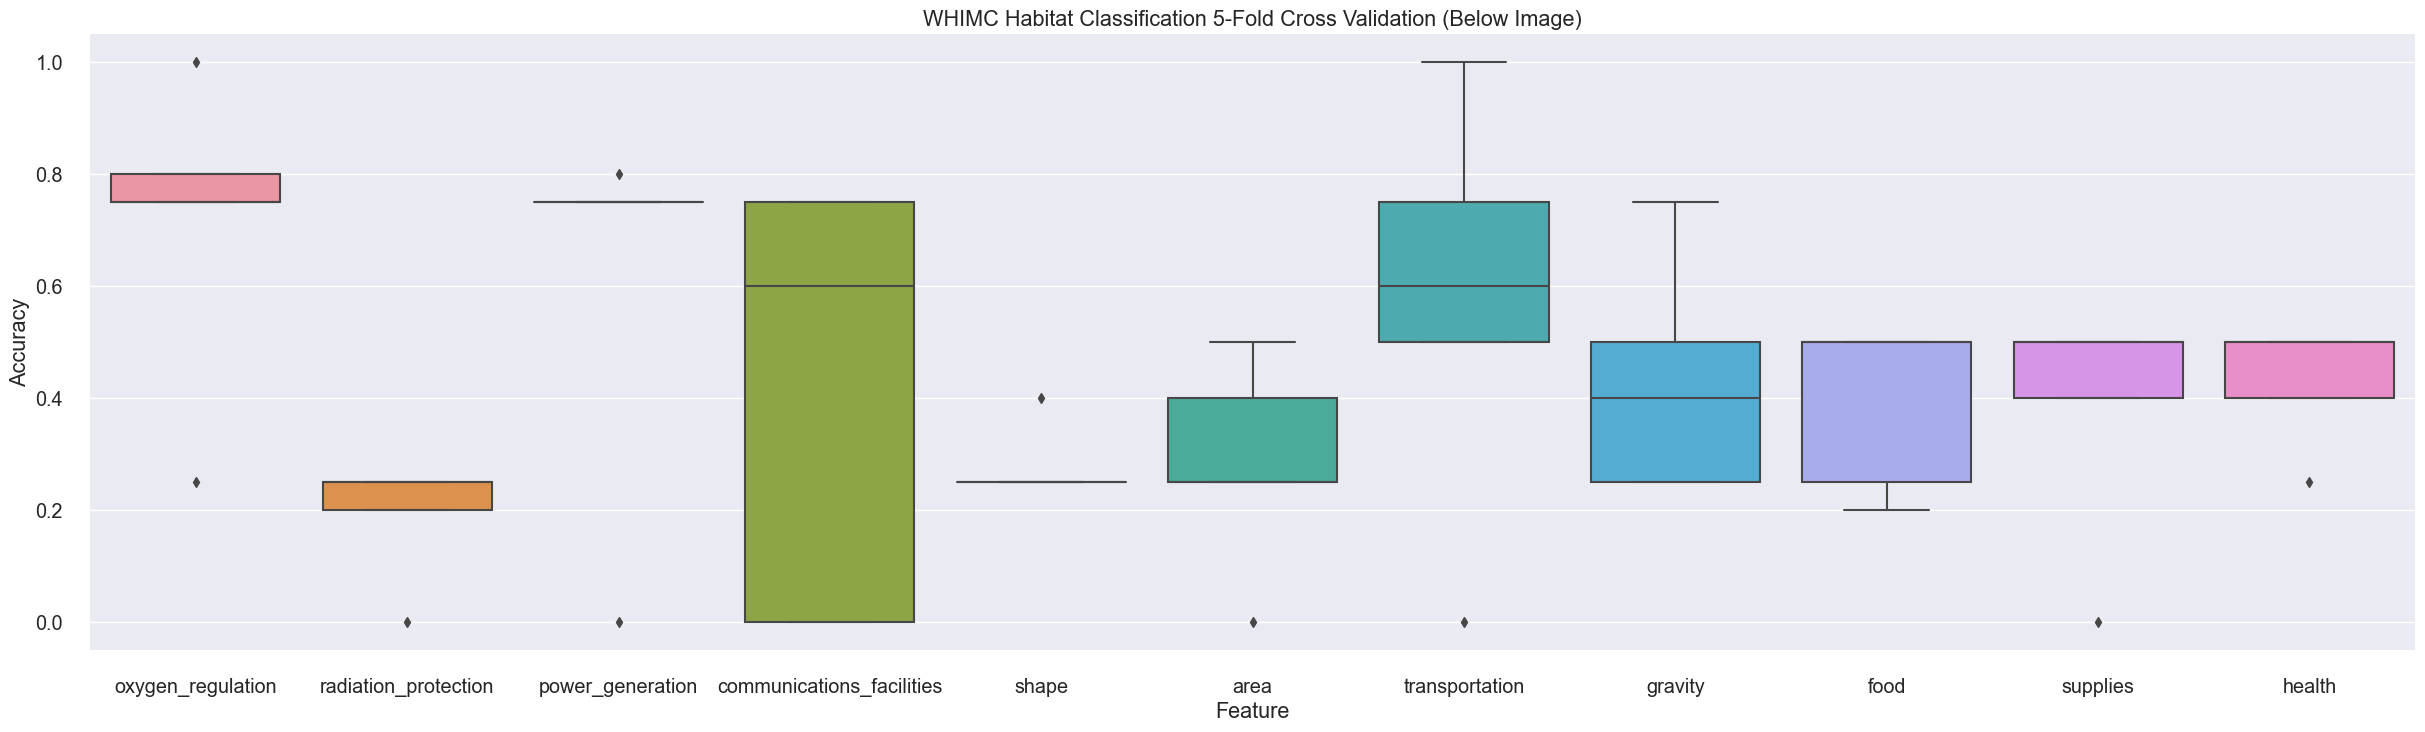

In [16]:
plt.figure()
x_label = 'Feature'
y_label = 'Accuracy'
title = 'WHIMC Habitat Classification '+str(splits)+"-Fold Cross Validation (Below Image)"
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_accuracy).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"accuracy.png")

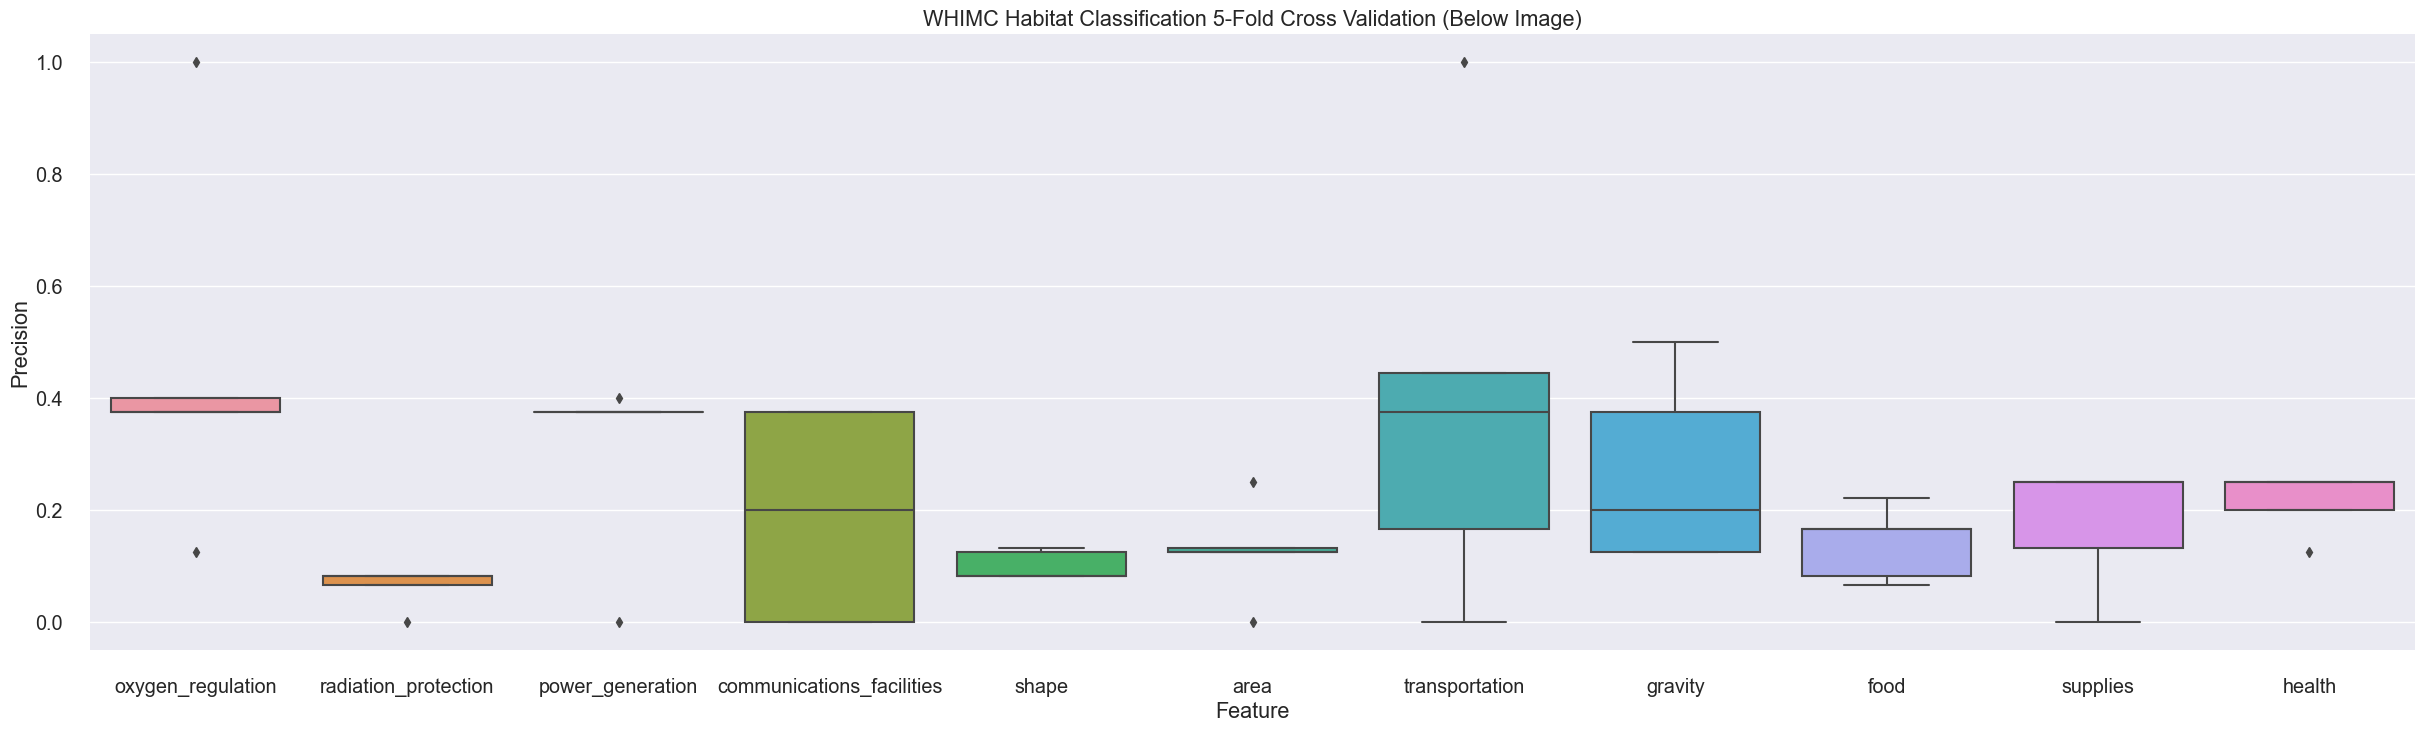

In [13]:
plt.figure()
x_label = 'Feature'
y_label = 'Precision'
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_precision).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"precision.png")

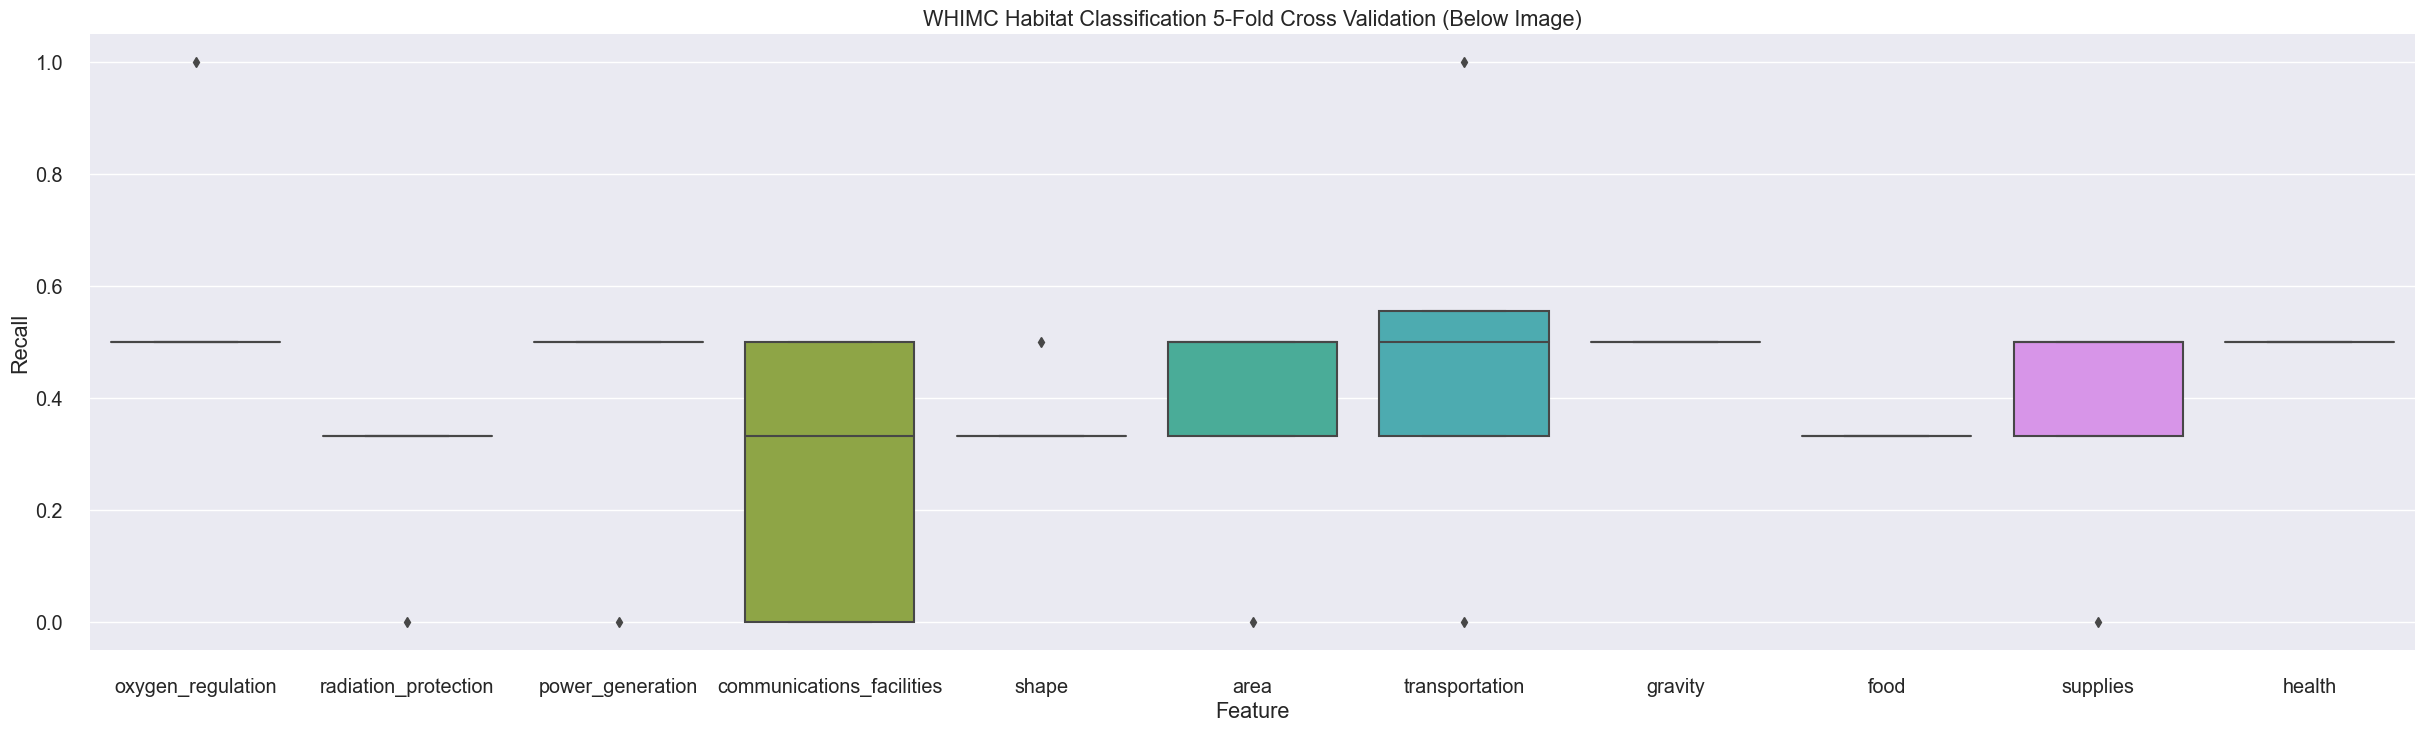

In [14]:
plt.figure()
x_label = 'Feature'
y_label = 'Recall'
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_recall).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"recall.png")

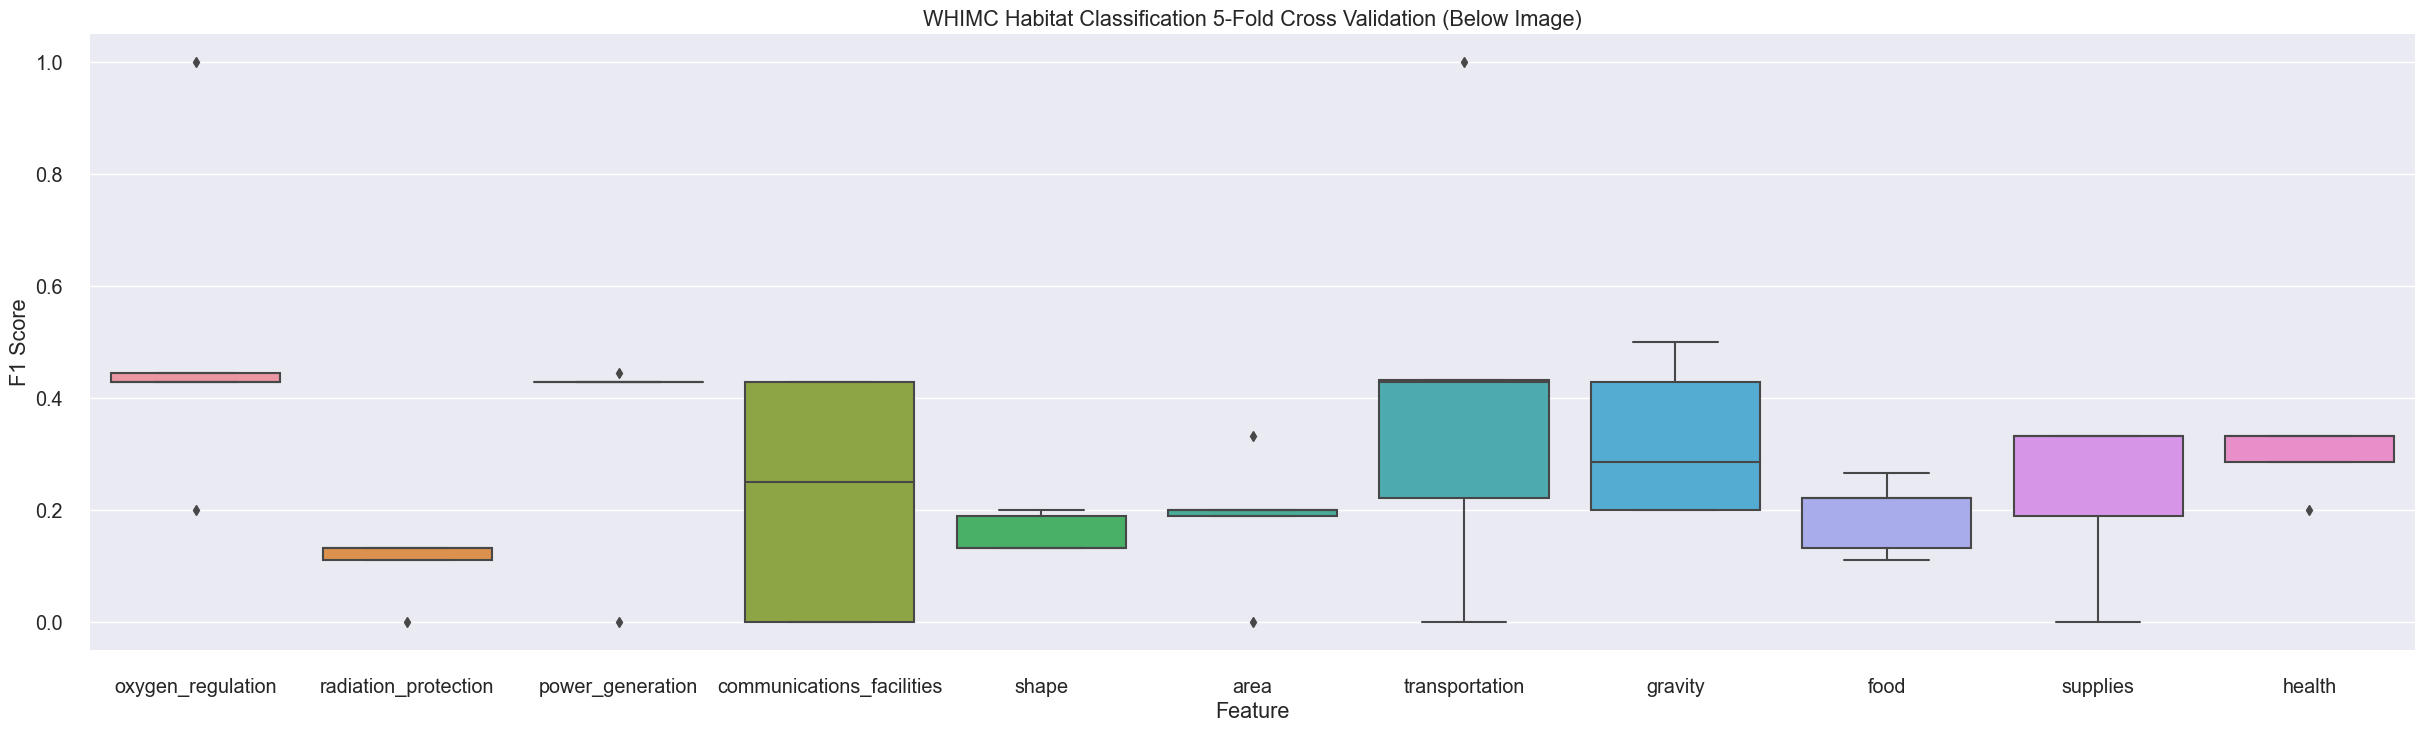

In [15]:
plt.figure()
x_label = 'Feature'
y_label = 'F1 Score'
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_f1).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"f1.png")